In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
from datetime import datetime
from os import path
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

mpl.style.use('ggplot')

In [3]:
path_to_train = path.join(path.abspath('..'), 'data', 'train.csv')
path_to_test = path.join(path.abspath('..'), 'data', 'test.csv')

train = pd.read_csv(path_to_train)

features = [col for col in train.columns if col not in ['id', 'target']]
obj_cols = [col for col in features if train[col].dtype == np.object]
num_cols = [col for col in features if train[col].dtype == np.float64]

train[obj_cols] = train[obj_cols].fillna(value='NAN')
train[num_cols] = train[num_cols].fillna(value=-1)

for col in obj_cols:    
    encoder = LabelEncoder()    
    train[col] = encoder.fit(train[col]).transform(train[col])

In [4]:
def plot_features(feature, marker=None, sort=False):
    fig, ax = plt.subplots(1, 3, figsize=(17,4))
    if sort:
        train.groupby(feature)['target'].mean().sort_values().plot(ax=ax[0], marker=marker)
    else:
        train.groupby(feature)['target'].mean().plot(ax=ax[0], marker=marker)
    return ax

In [5]:
def make_group(df, feature, n_groups=10):
    new_feature = feature + '_' + str(n_groups)
    nobs = len(df) / n_groups
    grouped = df.groupby(feature)['target'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
    grouped[new_feature] = np.floor(grouped['count'].cumsum() / nobs)
    groups = grouped[new_feature].unique()
    grouped.loc[grouped[new_feature] == groups[-1], new_feature] = groups[-2]
    grouped.reset_index(level=feature, inplace=True)
    columns = [col for col in df.columns if col not in [new_feature]]
    df=df[columns].merge(grouped[[feature, new_feature]], how='left', on=feature)
    df[new_feature] = df[new_feature].astype('int')
    return df

In [6]:
train = make_group(train, 'nom_5', n_groups=20)
train = make_group(train, 'nom_6', n_groups=20)
train = make_group(train, 'nom_9', n_groups=20)

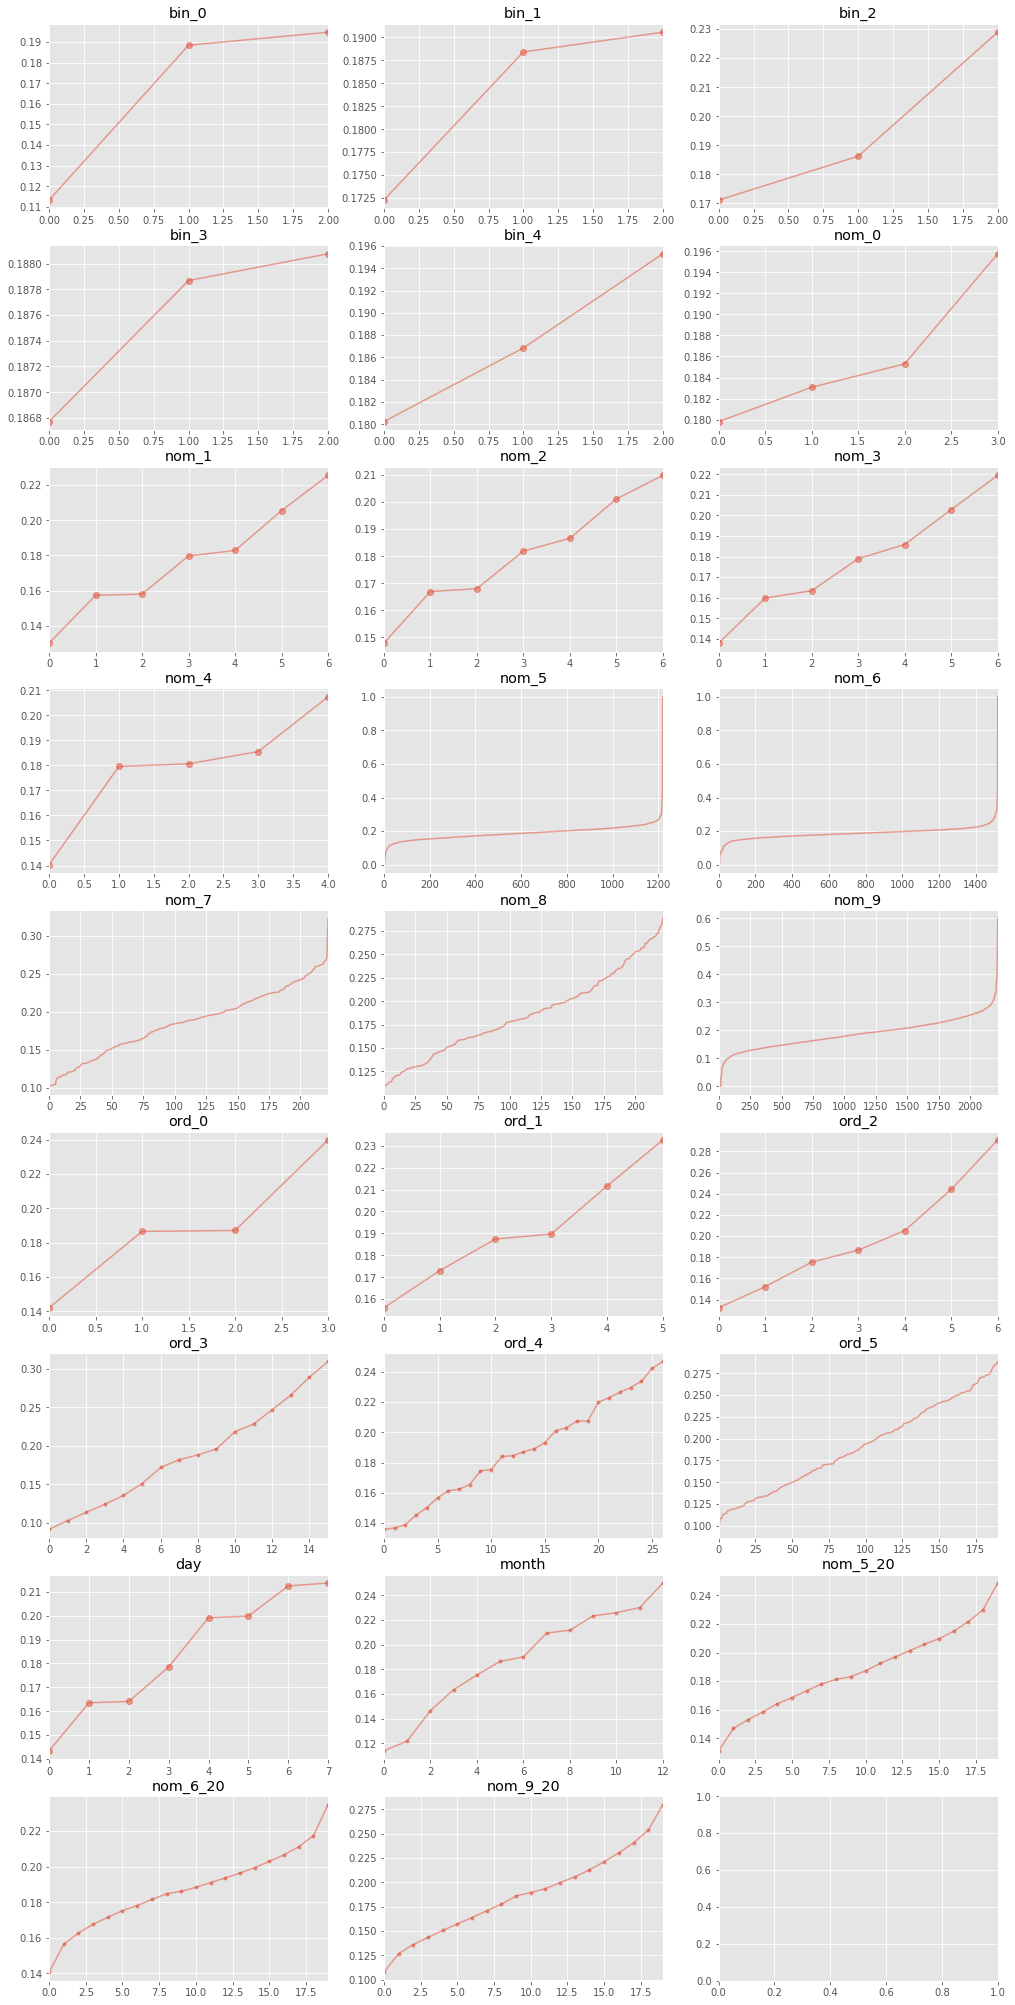

In [7]:
features = [col for col in train.columns if col not in ['id', 'target']]
ncols = 3
nrows = int(np.ceil(len(features) / ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(17,nrows * 4))

for i in range(nrows):
    for j in range(ncols):
        fid = ncols * i + j
        
        if fid < len(features):
            if train[features[fid]].nunique() <= 10:
                train.groupby(features[fid])['target'].mean().sort_values().reset_index(drop=True).plot(
                    ax=ax[i, j], alpha=0.5, title=features[fid], marker='o')
            elif train[features[fid]].nunique() <= 50:
                train.groupby(features[fid])['target'].mean().sort_values().reset_index(drop=True).plot(
                    ax=ax[i, j], alpha=0.5, title=features[fid], marker='.')
            else:
                train.groupby(features[fid])['target'].mean().sort_values().reset_index(drop=True).plot(
                    ax=ax[i, j], alpha=0.5, title=features[fid])
            ax[i, j].set_xlabel('')

In [8]:
train_x, test_x, train_y, test_y = train_test_split(
    train[features], 
    train['target'], 
    shuffle=True, 
    train_size=0.7, 
    random_state=42)    

In [9]:
def show_weights(expl):
    for row in expl.itertuples():
        print(f'{row.feature:8s}: {100*row.weight:5.2f} +- {100*2*row.std:.3f}')

In [10]:
estimator = lgb.LGBMClassifier(n_estimators=50)
estimator.fit(train_x, train_y, categorical_feature=features)

# initialize permutation importance class
perm_estimator = PermutationImportance(
    estimator=estimator, 
    scoring=make_scorer(roc_auc_score, needs_proba=True),
    n_iter=3)
perm_estimator.fit(test_x, test_y)

# calculate feature weights and return it as DataFrame
expl = eli5.format_as_dataframe(
    eli5.explain_weights(
        perm_estimator,
        top=None,
        feature_names=features
    )
)

In [11]:
show_weights(expl)

ord_3   :  7.87 +- 0.145
ord_2   :  3.02 +- 0.040
ord_5   :  2.48 +- 0.016
month   :  2.06 +- 0.057
nom_8   :  1.99 +- 0.097
ord_0   :  1.96 +- 0.058
nom_7   :  1.79 +- 0.015
nom_9_20:  1.33 +- 0.024
ord_4   :  1.08 +- 0.070
nom_1   :  0.62 +- 0.046
ord_1   :  0.55 +- 0.017
bin_0   :  0.53 +- 0.037
bin_2   :  0.50 +- 0.051
nom_3   :  0.36 +- 0.022
day     :  0.34 +- 0.019
nom_5_20:  0.25 +- 0.023
nom_2   :  0.14 +- 0.038
nom_5   :  0.12 +- 0.039
nom_4   :  0.08 +- 0.007
nom_6   :  0.03 +- 0.065
nom_6_20:  0.03 +- 0.001
nom_9   :  0.01 +- 0.031
nom_0   :  0.00 +- 0.000
bin_4   :  0.00 +- 0.000
bin_3   :  0.00 +- 0.000
bin_1   :  0.00 +- 0.000


In [24]:
path_to_train = path.join(path.abspath('..'), 'data', 'train.csv')
path_to_test = path.join(path.abspath('..'), 'data', 'test.csv')

train = pd.read_csv(path_to_train)


test=pd.read_csv(path_to_test)

In [29]:
tr = train['nom_6'].unique()
te = test['nom_6'].unique()
[x for x in te if x not in tr]

[nan, 'a885aacec']

[nan]